# Horizon detection using Dynamic Programming
Based on A robust dynamic programming algorithm to extract skyline in images for navigation by Wen-Nung Liea,*, Tom C.-I. Lina, Ting-Chih Lina, Keng-Shen Hung.
https://www.sciencedirect.com/science/article/pii/S0167865504002302 

## Algorithm Overview
- A skyline curve is a set of contiguous edge points that often extend from one side of the image to the other side.
- Sky line extraction is then modeled as a dynamic programming (DP) problem that searches a path or linkage by optimizing preselected preferences or cost.
- Gaussian smoothening is performed in th first step.
- After that edge detection using filters like Sobel/Canny is performed.
- The detected edges are thresholded using Balanced histogram thresholding, OTSU or mean thresholding.
<br>
<br>
![image](elen_644_dp_workflow.png)

## Edge map for Dynamic Programming
An edge map is created to perform dynamic programming in order to connect the edges and form a skyline and hence detect the horizon. The steps to create the edge map are given below.
- First, we use the M X N binary edge map {b<sub>ij</sub> | b<sub>ij</sub> = 1 or 0, i = 1,. . . ,M, j = 1,. . . ,N} to construct a multi-stage graph G = {V,L,W,U}.
- Each point b<sub>ij</sub> in the map corresponds to one node or vertex v<sub>i,j</sub> belonging to V in the j-th stage of the graph; v<sub>i,j</sub> is attributed as an edge vertex if b<sub>ij</sub> = 1 and as a non-edge vertex if b<sub>ij</sub> = 0.
- Two virtual vertices, s and t, are added in the front and rear end, respectively, of the graph to represent the 0<sup>th</sup> and the (N + 1)<sup>th</sup> stages.
- A link l<sub>h,k,j</sub> belonging to L is established between two edge vertices of adjacent stages, i.e., v<sub>h,j</sub> and v<sub>k,j+1</sub>.
- Associate each vertex v<sub>i,j</sub> with a cost function $$\psi(i,j):$$
![eqn1](eqn1.png)
This steps associates high cost to horizon line lower in the image.
- Associate each link lh,k,j with a cost function
$$\Phi(h,k,j):$$
![eqn2](eqn2.png)

## Example graph
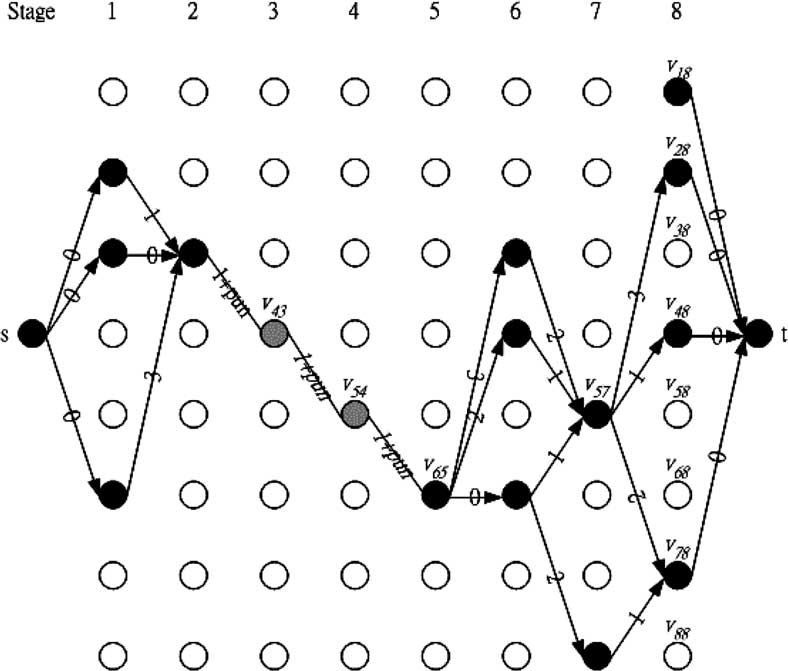

### Bridging the tolerance gap
Since the skyline curve may be disconnected due to poor image contrast or bad thresholding, the paper describes the criteria of tolerance gap(ToG) in order to connect edge pixels which do not lie in adjacent columns.  An expansion search can be performed to bridge the tolerance gap. This feature is not present our implementation.
![TOG](tog.png)

In [35]:
import numpy as np
import os
import cv2
import inspect
import matplotlib.pyplot as plt
import time
from PIL import Image
from scipy.ndimage.filters import convolve
from scipy.misc import imsave
from edge_detect import EdgeDetector
from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive
from scipy.ndimage.filters import gaussian_filter

### Function to convert RGB image to Grayscale

In [36]:
def rgb2grayscale(im):
        """
            Converts RGB to Grayscale.
            @params: Input RGB image.
            @return: Grayscale image(1 channel)
        """
        if  len(im.shape) > 2:
            if im.shape[2] == 3: # Convert RGB image to Grayscale
                r, g, b = im[:, :, 0], im[:, :, 1], im[:, :, 2]
                grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
                return grayscale
        else:
            return im

### Set input image path

In [37]:
input_file = 'input/horizon3.jpg'
#input_file = 'input/image10.png'

## Perform Edge Detection using Sobel Filter
This code uses the edge detector developed for Mini Project 1

Saving out/horizon3_sobel.jpg
Threshold  5
Threshold  5
Saving out/horizon3_sobel_BHT.jpg


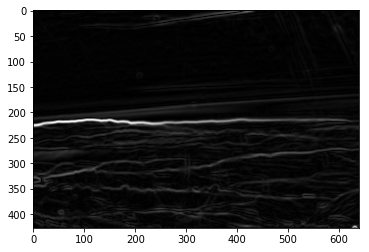

In [38]:
edge = EdgeDetector()
edge_img, edge_angle = edge.sobel(input_file)
plt.imshow(edge_img, cmap='gray')

## Thresholding
We use Balanced Histogram Thresholding to binarize the image.

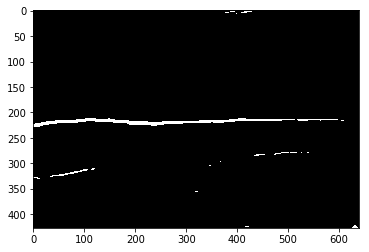

In [39]:
img_file = 'out/'+input_file.split('/')[1].split('.')[0]+'_sobel.jpg'
img = np.array(Image.open(img_file))
img_gray = rgb2grayscale(np.array(img))
width, height = img.shape
global_thresh = threshold_otsu(img_gray)
binary_global = img > global_thresh
plt.imshow(binary_global, cmap='gray')

### Output after edge detection and thersholding
The edge detected and thresholded output is saved in binary_global

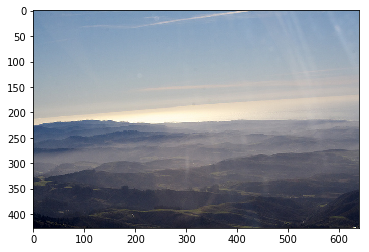

In [40]:
plt.imshow(plt.imread(input_file))

### Original Image

## Algorithm implmentation

$$ \text{Here }\delta \text{ is set to }10$$

In [41]:
class Horizon:
    def __init__(self, img):
        self.img  = img
        self.height, self.width = img.shape
        self.positions = np.zeros(img.shape)
        self.stop = False
        self.horizon = [[]]
        self.cost = [0]
        self.success = [False]
        self.y_range = 10
    
    #Function to find the horizon starting point on the left edge
    def find_start(self):
        for i in range(self.height):
            if self.img[i,0]:
                return(i,0)
    
    # Function to solve for 
    def solve(self):
        start_pix = self.find_start()
        attempt = 0
        while start_pix[0] < self.height:
            if img[start_pix]:
                if not self.put_pixel(start_pix, attempt):
                    # print("Starting at ", start_pix)
                    start_pix =(start_pix[0]+1, 0)
                    attempt += 1
                    self.horizon.append([])
                    self.cost.append(start_pix[0]**2)
                    self.success.append(False)
            else:
                start_pix =(start_pix[0]+1, 0)
        
    def put_pixel(self, curr_pix, attempt):
        curr_y,x = curr_pix
        self.horizon[attempt].append(curr_pix)
        if x == self.width-1:
            self.stop = True
            self.success[attempt] = True
        else:
            y = curr_y
            if curr_y - self.y_range > 0:
                min_y = curr_y - self.y_range
            else:
                min_y = 0
            while y < min(curr_y + self.y_range, self.height):
                if img[y,x]:
                    condition, index, cost = self.find_next((curr_y,y,x))
                    if condition is True:
                        #print(cost, index, curr_y)
                        self.cost[attempt] += cost
                        return self.put_pixel(index, attempt)
                        if self.stop:
                            break
                y += 1
            return False
        
    # Function to find link in the next column           
    def find_next(self, curr_pix,i=1):
        curr_y,y,x = curr_pix
        col = x+i
        min_cost = float('Inf')
        index = -1
        flag = False
        if curr_y - self.y_range > 0:
            min_y = curr_y - self.y_range
        else:
            min_y = 0
        if curr_y + self.y_range < self.height:
            max_y = curr_y + self.y_range
        else:
            max_y = self.height
        #print(min_y,max_y)
        #for j in range(self.height):
        for j in range(min_y, max_y):

            if img[j,col]:
                cost = abs(curr_y-j)
                if cost < min_cost:
                    min_cost = cost
                    index = j
                    flag = True
                if min_cost > self.y_range:
                    flag = False
        return flag, (index, x+1), min_cost        
        #return flag, (index, x+1), cost        

## Apply the algorithm on the thresholded image

In [42]:
h = Horizon(binary_global)

In [43]:
start_time = time.time()
h.solve()
end_time = time.time()

## Initialize a empty mask

In [44]:
mask = np.zeros(img.shape)

## Find the path with minimum cost
We look for the path which has minimum cost with successful connection of edges across the width of the image

In [45]:
min_cost_final = float("Inf")
i = 0
index = None
for cost, success in zip(h.cost,h.success):
    #print(cost, success)
    if success:
        if cost < min_cost_final:
            min_cost_final = cost
            index = i
            #print(index, cost)
    i += 1
print(index)

0


### Create the mask and mark the horizon pixels

In [46]:
mask = np.zeros(img.shape, dtype=np.uint8)
for x in h.horizon[index]:
    mask[x] = 255

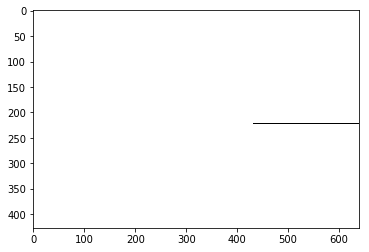

In [47]:
plt.imshow(mask, cmap='binary')

## Detected Horizon

In [48]:
im = cv2.imread(input_file)
for i in range(width):
    for j in range(height):
        if mask[i,j]:
            im[i,j,2] = 255

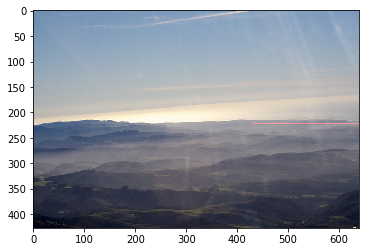

In [49]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

## Detect horizon marked on the original image
Save the output image

In [50]:
outfile = 'out/'+input_file.split('/')[1].split('.')[0]+'_dp.jpg'
plt.imsave(outfile, cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [51]:
print("Time taken to by the DP step {} seconds".format(end_time-start_time))

Time taken to by the DP step 1.972085952758789 seconds


## Results

![horizon1](test1.jpg)
![horizon1](test1_out.jpg)
![horizon2](test2.jpg)
![horizon2](test2_out.jpg)

## Failing example
In the example below the algorithm fails to find a starting point as the horizon edge is faintly detected in the sobel filter output and is suppressed in the thresholding stage. Also the implementation has not provision to handle images where horizon does not end at the right end of the image.

![fail](fail.jpg)
![fail_sobel](fail_sobel.jpg)
![fail_BHT](fail_sobel_BHT.jpg)